runs log
- MLP 3 layer with residual, @ 3795 paarmeters = 15500: train loss = 1.29, validation loss = 1.642946
- MLP 3 layer with residual, @ 2595 parameters = 21000: train loss = 1.47, validation loss = 1.730679
- MLP 2 layer with residual, @ 1795 parameters = 21000: train loss = 1.66, validation loss = 1.783541
- MLP 1 layer with residual, @ 795 parameters = 29000: train loss = 1.70, validation loss = 1.873574
- MLP baseline @ 2195 parameters: train loss = 1.45, validation loss = 1.688287

# Environment

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-02-17 05:57:19--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2025-02-17 05:57:19 (57.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [4]:
import torch

# 1. Define a device variable. If a GPU is available, use it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available CUDA devices
    num_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_devices)

    # Get information about the current device
    current_device_id = torch.cuda.current_device()
    print("Current device ID:", current_device_id)

    # Get the name of the current device
    device_name = torch.cuda.get_device_name(current_device_id)
    print("Device name:", device_name)

    # Get detailed device properties
    device_props = torch.cuda.get_device_properties(current_device_id)
    print("Device properties:", device_props)

    # Get memory information
    memory_allocated = torch.cuda.memory_allocated(current_device_id)
    memory_reserved = torch.cuda.memory_reserved(current_device_id)
    print("Memory allocated:", memory_allocated)
    print("Memory reserved:", memory_reserved)
else:
    print("CUDA is not available.")

Using device: cuda
Number of CUDA devices: 1
Current device ID: 0
Device name: NVIDIA RTX A4000
Device properties: _CudaDeviceProperties(name='NVIDIA RTX A4000', major=8, minor=6, total_memory=16108MB, multi_processor_count=48)
Memory allocated: 0
Memory reserved: 0


In [5]:
!nvidia-smi

Fri Feb 21 07:12:56 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   40C    P8    15W / 140W |   1517MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
hyperparams = {
    'block_size': 8,
    'embedding_dim': 24,
    'hidden_layer': 1024,
    'batch_size': 3000,
    'epochs': 100000,
    'attention_size': 32
}

# Shakespeare dataset

In [6]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
characters = set()
for c in text:
    characters.add(c)
vocab_size = len(characters)
int_to_characters = {i: c for i, c in enumerate(characters)}
characters_to_int = {c: i for i, c in enumerate(characters)}

CONTEXT_WINDOW = hyperparams['block_size']

X, y = [], []
k = 0
X_train, X_test, y_train, y_test = [], [], [], []
for k in range(int(len(text) * 0.90)):
    xx = text[k:k+CONTEXT_WINDOW]
    yy = text[k+CONTEXT_WINDOW]

    X_train.append([characters_to_int[c] for c in xx])
    y_train.append(characters_to_int[yy])

for k in range(int(len(text) * 0.92), len(text) - 2*CONTEXT_WINDOW):
    xx = text[k:k+CONTEXT_WINDOW]
    yy = text[k+CONTEXT_WINDOW]

    X_test.append([characters_to_int[c] for c in xx])
    y_test.append(characters_to_int[yy])
    
import torch
X_train, y_train = torch.tensor(X_train, device=device), torch.tensor(y_train, device=device)
X_train.shape, y_train.shape

X_val, y_val = torch.tensor(X_test, device=device), torch.tensor(y_test, device=device)
X_val.shape, y_val.shape

ix = torch.randint(0, X_train.shape[0], (4,))
X_train[ix], y_train[ix]

(tensor([[17, 20, 49, 18, 45,  4, 20, 17],
         [59, 48,  4, 13,  0, 18,  4, 27],
         [45,  0,  4, 25, 18, 18,  0, 49],
         [ 4, 17, 20, 49,  4, 45, 50, 55]], device='cuda:0'),
 tensor([ 4,  0, 43,  4], device='cuda:0'))

In [239]:
len(text)

1115394

(torch.Size([1003854, 6]), torch.Size([1003854]))

(torch.Size([89220, 6]), torch.Size([89220]))

(tensor([[30, 61, 42, 47, 14, 14],
         [61, 42,  0, 60, 62, 25],
         [ 2, 60, 14, 43, 29, 44],
         [44, 11,  6, 26,  0,  0]], device='cuda:0'),
 tensor([21, 49,  1, 16], device='cuda:0'))

# Model

In [387]:
from torch import nn

In [388]:
# input
# embedding layer
# masked multi hjead attention 
# add and norm
# feed forward
# add norm
# linear
# softmax
# probabilities

In [389]:
embedding_dim = hyperparams['embedding_dim']
block_size = hyperparams['block_size']
batch_size = hyperparams['batch_size']
hidden_layer_size = hyperparams['hidden_layer']
epochs = hyperparams['epochs']
attention_size = hyperparams['attention_size']

In [390]:
class ResidualMLPLayer(nn.Module):
    def __init__(self, fan_in, hidden_layer_size,device=device):
        # output is going to be fan_in * 2
        super().__init__()
        self.l1 = nn.Linear(fan_in, hidden_layer_size, device=device)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_layer_size, fan_in, device=device)
        self.layer_norm = nn.LayerNorm(fan_in, device=device)
    
    def forward(self, x):
        mlp = self.l1(x)
        mlp = self.relu(mlp)
        mlp = self.l2(mlp)
        x = x + mlp
        x = self.layer_norm(x)
        self.out = x
        return self.out
    
class ScaledDotProductAttention(nn.Module):
    
    def __init__(self, fan_in, query_size = 64, value_size = 64, device=device):
        # fan_in = embedding_dim
        super().__init__()
        self.query_layer = nn.Linear(fan_in, query_size, device=device)
        self.key_layer = nn.Linear(fan_in, query_size, device=device)
        self.value_layer = nn.Linear(fan_in, value_size, device=device)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        query = self.query_layer(x)
        key = self.key_layer(x)
        attention = (query @ key.transpose(2, 1)) / math.sqrt(query_size)
        mask = torch.tril(torch.ones_like(attention, dtype=torch.bool))
        masked_attention = attention.masked_fill(~mask, float('-inf'))
        masked_attention = F.softmax(masked_attention, dim=2)
        
        value = self.value_layer(x)
        x = (masked_attention @ value)
        self.out = x
        return self.out
    
class MultiHeadAttention(nn.Module):
    
    def __init__(self, fan_in, heads=2, query_size = 64, value_size = 64, device=device):
        super().__init__()
        self.value_size = value_size
        self.heads = heads
        self.attention_heads = nn.ModuleList([
            ScaledDotProductAttention(fan_in, query_size, value_size, device) for _ in range(heads)])
        self.linear = nn.Linear(value_size * heads, fan_in, device=device)
        self.norm = nn.LayerNorm(fan_in, device=device)
        
    def forward(self, x):
        out = [attention_head(x) for attention_head in self.attention_heads]
        out = torch.cat(out, dim=2)
        out = self.linear(out) + x # add
        out = self.norm(out) # norm
        self.out = out
        return self.out
        
    
model = nn.Sequential(
    nn.Embedding(vocab_size, embedding_dim, device=device), 
    MultiHeadAttention(embedding_dim, heads=2, query_size=attention_size, value_size=attention_size, device=device),
    nn.Flatten(),
    ResidualMLPLayer(embedding_dim * block_size, hidden_layer_size, device=device),
    nn.Linear(embedding_dim * block_size, vocab_size, device=device) 
)
        

In [391]:
model

Sequential(
  (0): Embedding(65, 12)
  (1): MultiHeadAttention(
    (attention_heads): ModuleList(
      (0-1): 2 x ScaledDotProductAttention(
        (query_layer): Linear(in_features=12, out_features=32, bias=True)
        (key_layer): Linear(in_features=12, out_features=32, bias=True)
        (value_layer): Linear(in_features=12, out_features=32, bias=True)
        (flatten): Flatten(start_dim=1, end_dim=-1)
      )
    )
    (linear): Linear(in_features=64, out_features=12, bias=True)
    (norm): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): ResidualMLPLayer(
    (l1): Linear(in_features=72, out_features=1024, bias=True)
    (relu): ReLU()
    (l2): Linear(in_features=1024, out_features=72, bias=True)
    (layer_norm): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
  )
  (4): Linear(in_features=72, out_features=65, bias=True)
)

In [408]:
ix = torch.randint(0, X_train.shape[0], (batch_size,))
x, y = X_train[ix], y_train[ix]
x.shape

torch.Size([3000, 6])

In [409]:
x = model[0](x)
x.shape

torch.Size([3000, 6, 12])

In [411]:
x = model[1](x)
x.shape

torch.Size([3000, 6, 12])

In [415]:
W1 = torch.randn(12, 256, device=device)
W1.shape

torch.Size([12, 256])

In [417]:
(x @ W1).shape

torch.Size([3000, 6, 256])

In [ ]:
x = model

In [393]:
x = model(x)
x.shape

torch.Size([3000, 65])

In [394]:
parameters = 0
for p in model.parameters():
    p.require_grad=True
    parameters += len(p)
print(parameters)
    

2963


In [395]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [404]:
#lossi, vlossi = [], []

epochs = 100000
for i in range(epochs):
    # forward pass
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    x, y = X_train[ix], y_train[ix]
    x = model(x)
    loss = nn.functional.cross_entropy(x, y)
    

    
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    
    # update
    optimizer.step()
        
    lossi.append(loss.item())
    if i % 500 == 0:
        with torch.no_grad():
            # validation loss
            logits_val = model(X_val)
            loss_val = nn.functional.cross_entropy(logits_val, y_val)
            vlossi.append(loss_val.item())
            print(f"{i}: train loss = {loss.item():.2f}, validation loss = {loss_val.item():2f}")

0: train loss = 1.53, validation loss = 1.749238
500: train loss = 1.45, validation loss = 1.745902
1000: train loss = 1.45, validation loss = 1.749490
1500: train loss = 1.52, validation loss = 1.749633
2000: train loss = 1.50, validation loss = 1.743027
2500: train loss = 1.52, validation loss = 1.742851
3000: train loss = 1.46, validation loss = 1.743725
3500: train loss = 1.45, validation loss = 1.744512
4000: train loss = 1.47, validation loss = 1.739130
4500: train loss = 1.45, validation loss = 1.739299
5000: train loss = 1.51, validation loss = 1.741496
5500: train loss = 1.45, validation loss = 1.740738
6000: train loss = 1.50, validation loss = 1.735005
6500: train loss = 1.51, validation loss = 1.734494
7000: train loss = 1.47, validation loss = 1.733595
7500: train loss = 1.49, validation loss = 1.738437
8000: train loss = 1.49, validation loss = 1.734705
8500: train loss = 1.49, validation loss = 1.734535
9000: train loss = 1.42, validation loss = 1.734115
9500: train loss

KeyboardInterrupt: 

In [403]:
lossi = list(x.item() for x in lossi)

In [406]:
lossi = torch.tensor(lossi)

/tmp/ipykernel_4107/197717029.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lossi = torch.tensor(lossi)


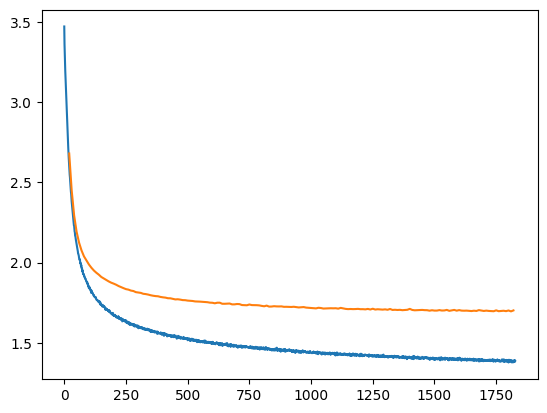

In [407]:
plot_dim = len(vlossi) * 10
start = 2
from matplotlib import pyplot as plt
plt.plot(lossi[:plot_dim * (lossi.numel() // plot_dim)].view((plot_dim, -1)).mean(1)[start:])
plt.plot([i * 10 for i in range(len(vlossi))][start:], vlossi[start:])

In [89]:
model.layers

[Embedding(65, 10),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=100, out_features=200, bias=True),
 ReLU(),
 Linear(in_features=200, out_features=100, bias=True),
 Linear(in_features=200, out_features=65, bias=True)]

In [90]:
model.layers[-1].weight.T.shape

torch.Size([200, 65])

In [88]:
model.layers[-1].bias.shape

torch.Size([65])

In [92]:
last_layer = model.layers[-1].weight.T.clone()

In [121]:
print(f"L2 norm of contirbution from residuals = {last_layer[:100, :].norm().item()}")
print(f"L2 norm of contirbution from MLP = {last_layer[100:, :].norm().item()}")

L2 norm of contirbution from residuals = 7.358966827392578
L2 norm of contirbution from MLP = 11.672381401062012


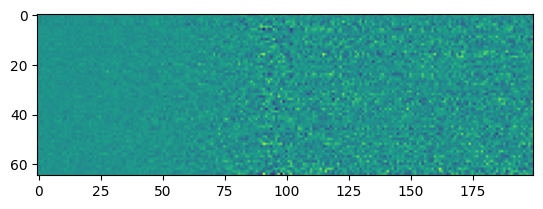

In [122]:
plt.imshow(last_layer.T.cpu().detach())

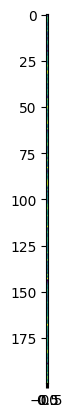

In [104]:
plt.imshow(last_layer.mean(1).view(200,1).cpu().detach())

<BarContainer object of 200 artists>

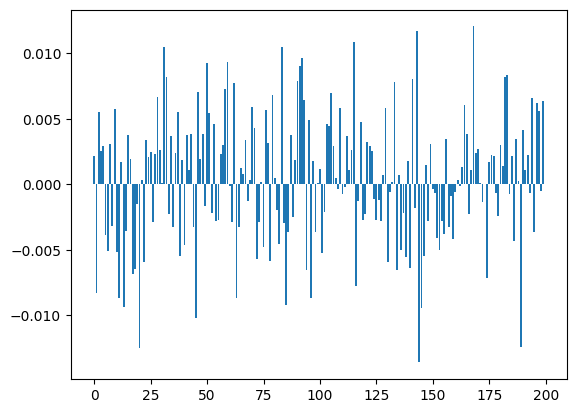

In [106]:
plt.bar(range(200), last_layer.mean(1).cpu().detach())

In [113]:
last_layer.mean(1).view(2,100).mean(1)

tensor([0.0004, 0.0004], device='cuda:0', grad_fn=<MeanBackward1>)